In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/processed.csv')
df.head()

,Unnamed: 0,difficulty,size,gas_limit,transaction_count,gas,past_min,past_mean,past_max,block_min
0,0,0.497304,1.525696,1.376636,0.768851,-0.306444,-0.471469,-0.552406,-0.503274,0.696954
1,1,-0.175685,-0.151892,0.634122,-0.146996,0.373021,0.021040,0.091190,0.868203,-0.093861
2,2,0.074976,-1.414733,-0.108392,-0.544231,-0.382288,-0.202041,-0.555886,-0.473770,-0.357466
3,3,0.730501,0.085234,0.634122,-0.334579,-0.348186,0.036881,-0.276384,-0.418639,-0.291564
4,4,1.549208,0.792288,0.634122,0.934365,-0.309031,-0.300726,-0.273407,-0.412249,0.433349


In [3]:
dfu = pd.read_csv('../Data/unscaled.csv')
dfu.head()

,Unnamed: 0,difficulty,size,gas_limit,transaction_count,gas,past_min,past_mean,past_max,block_min
0,0,6425575804636287,78173,15014647,278,51024,3.365059e+09,9.980774e+09,5.395000e+10,1.200000e+10
1,1,6349705712431105,53730,15000000,195,320000,7.158000e+09,2.022363e+10,1.060909e+12,6.000000e+09
2,2,6377964208248559,35330,14985353,159,21000,5.440000e+09,9.925386e+09,7.561275e+10,4.000000e+09
3,3,6451865431002786,57185,15000000,178,34500,7.280000e+09,1.437368e+10,1.160908e+11,4.500000e+09
4,4,6544163153880016,67487,15000000,293,50000,4.680000e+09,1.442106e+10,1.207825e+11,1.000000e+10


In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
dfu.drop(['Unnamed: 0'], axis=1, inplace=True)

## Train-Test split

In [5]:
from sklearn.model_selection import train_test_split
x = dfu
y = dfu['block_min']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[x_train_scaled.columns] = scaler.fit_transform(x_train_scaled[x_train_scaled.columns])
x_test_scaled[x_test_scaled.columns] = scaler.fit_transform(x_test_scaled[x_test_scaled.columns])
x_train_scaled.drop(['block_min'], axis=1, inplace=True)
x_test_scaled.drop(['block_min'], axis=1, inplace=True)

## Gridsearch to tune parameters

In [7]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(objective ='reg:squarederror')
no_of_estimators = [10, 30, 60, 100]
maximumdepth = [5, 10, 15, 25, 25]
parameters = {'n_estimators': no_of_estimators ,'max_depth': maximumdepth}
model = GridSearchCV(estimator=xgb, param_grid=parameters, cv=3, scoring='neg_root_mean_squared_error', return_train_score=True, verbose=1)
model.fit(x_train_scaled[:100000], y_train[:100000])

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
       

Model with best parameters :
 {'max_depth': 15, 'n_estimators': 100}


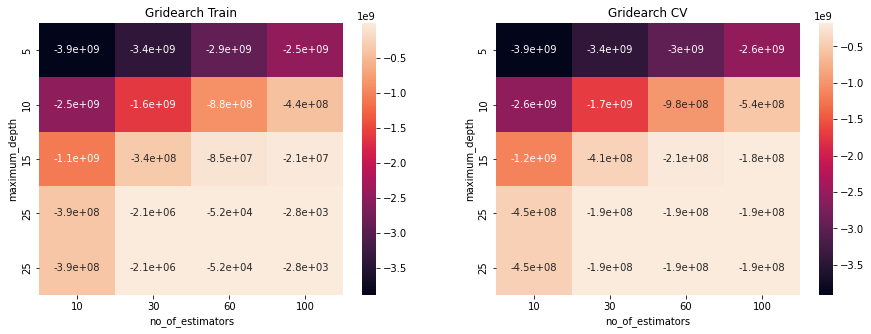

In [8]:
print("Model with best parameters :\n", model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(len(maximumdepth), len(no_of_estimators))
cv_auc = model.cv_results_['mean_test_score'].reshape(len(maximumdepth), len(no_of_estimators))

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title, xticklabels=no_of_estimators, yticklabels=maximumdepth, annot=True, ax=axes[i])
    axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("no_of_estimators")
    axes[i].set_ylabel("maximum_depth")

## Training the model

In [42]:
xgb_r = XGBRegressor(objective ='reg:squarederror', n_estimators=100, max_depth=25)
xgb_r.fit(x_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=25, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [43]:
y_pred = xgb_r.predict(x_test_scaled)

In [44]:
y_p_tr = xgb_r.predict(x_train_scaled)

In [45]:
def accuracy(y_pred,data):
    correct=0
    i=0
    for index,row in data.iterrows():
        if(y_pred[i]>=row['block_min'] and y_pred[i]<=row['past_max']):
            correct+=1
        i+=1
    acc = correct/data.shape[0]
    return acc 

In [46]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score, r2_score
from math import sqrt

def calculateMetric(y_pred, y_test, data):
    print("MAE=",mean_absolute_error(y_test,y_pred))
    print("RMSE=",sqrt(mean_squared_error(y_test,y_pred)))
    print("R2 Score", r2_score(y_test,y_pred))
    print("accuracy", accuracy(y_pred, data))

In [47]:
calculateMetric(y_pred, y_test, x_test)

MAE= 688614494.8876947
RMSE= 2187162942.8063807
R2 Score 0.917650284082174
accuracy 0.506207142059836


In [48]:
calculateMetric(y_p_tr, y_train, x_train)

MAE= 536.5724009470559
RMSE= 945.9011896641474
R2 Score 0.9999999999999843
accuracy 0.5565469456465103


## Saving the model

In [49]:
xgb_r.save_model('../weights/xgboost.json')

In [50]:
import xgboost as xgb

loaded = xgb.XGBRegressor()
loaded.load_model('../weights/xgboost.json')

In [51]:
y_pred2 = loaded.predict(x_test_scaled)

In [52]:
calculateMetric(y_pred2, y_test, x_test)

MAE= 688614494.8876947
RMSE= 2187162942.8063807
R2 Score 0.917650284082174
accuracy 0.506207142059836
